##### packages

In [47]:
import csv
import os
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import librosa

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import plotly.graph_objects as go
import anywidget
from scipy.ndimage import gaussian_filter
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### loading data

In [3]:
dataset = pd.read_csv("../../../moodo/dataset2.csv", header=None)

# columns: 0:2809 -> features, 2809:2816 -> targets
'''
targets in order (8): 
2809: 'SongID'
2810: 'H'
2811: 'S'
2812: 'V'
2813: 'Val'
2814: 'Ar'
2815: 'Emotion'
2816: 'EmotionEncoded'
'''
print(dataset.shape)

(76034, 2816)


In [4]:
# included : stop before
print(dataset.shape)

filtered_data = dataset.drop(columns=[2809, 2815]).values
final_data = filtered_data[:, :-6]
label_array = filtered_data[:, -1]
hsv_array = filtered_data[:, -6:-3]

print(filtered_data.shape)


emotion_mapping = dict(zip(dataset.iloc[:, -2].unique(), dataset.iloc[:, -1].unique()))
emotion_mapping = dict(sorted(emotion_mapping.items(), key=lambda x: x[1])) # sort by value
emotion_mapping = {k: int(v) for k, v in emotion_mapping.items()} # convert to int
print("Emotion Mapping:", emotion_mapping)

(76034, 2816)
(76034, 2814)
Emotion Mapping: {'Anger': 0, 'Anticipation': 1, 'Calmness': 2, 'Dreamy': 3, 'Fear': 4, 'Gloominess': 5, 'Happiness': 6, 'Inspiring': 7, 'Joy': 8, 'Liveliness': 9, 'Longing': 10, 'Relaxed': 11, 'Sadness': 12, 'Surprise': 13}


In [6]:
n_split = -6 # last 6 columns: 'H', 'S', 'V', 'Val', 'Ar', 'EmotionEncoded'

features = final_data[:, :n_split].astype(np.float32)
labels = final_data[:, n_split:].astype(np.float32)

features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)
train_features, test_features, train_labels, test_labels = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=0)
print("Train features shape:", train_features.shape, "Test features shape:", test_features.shape)
print("Train labels shape:", train_labels.shape, "Test labels shape:", test_labels.shape)

class AudioDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(train_features, train_labels)
test_dataset = AudioDataset(test_features, test_labels)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

Train features shape: torch.Size([60827, 2802]) Test features shape: torch.Size([15207, 2802])
Train labels shape: torch.Size([60827, 6]) Test labels shape: torch.Size([15207, 6])


##### architecture

In [9]:
class AudioEmotionModel(nn.Module):
    def __init__(self):
        super(AudioEmotionModel, self).__init__()
        self.fc1 = nn.Linear(2802, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 6)  # outputs 'H', 'S', 'V', 'Val', 'Ar', 'EmotionEncoded'
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = AudioEmotionModel().to(device)

##### training

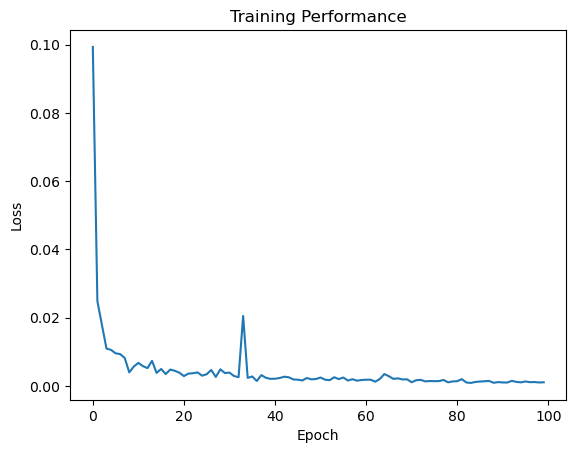

In [10]:
lr = 0.001
epochs = 100
lf = nn.MSELoss()
# lf = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
va_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lf(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = lf(outputs, targets)
            val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        print(f'Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}', end='\r')
    
# generate loss plot
plt.plot(losses)
plt.plot(va_losses)
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
torch.save(model.state_dict(), f'model_epoch{epochs}.pth')

##### testing

In [12]:
model.eval()
total_loss = 0.0
n_correct = 0
with torch.no_grad():
    # inputs: X, targets: y
    # print(test_loader.dataset.X.shape, test_loader.dataset.y.shape)
    n_samples = len(test_loader.dataset)
    
    for inputs, targets in test_loader: # in batches of 32
        outputs = model(inputs)
        loss = lf(outputs, targets)
        total_loss += loss.item()
        
        correct = [torch.all(torch.eq(targets[i], outputs[i])) for i in range(inputs.size(0))]
        n_correct += len(correct)

avg_test_loss = total_loss / n_samples
accuracy = n_correct / n_samples * 100
print(f'Test Loss: {avg_test_loss:.4f} | Accuracy: {n_correct}/{n_samples} ({accuracy:.3f}%)')

Test Loss: 0.0001 | Accuracy: 15200/15207 (99.954%)


In [13]:
indices = {}
with open('../../../moodo/indices.txt') as file:
    for line in file:
        song_id, _, start, end = line.split(',')
        indices[song_id] = (int(start), int(end))

print(len(indices))

200


In [205]:
class tester():
    def __init__(self, song_id):
        self.mp3_file = f'../../../moodo/audio/{song_id}.mp3'
        self.song_id = song_id
        
        self.i_start, self.i_end = indices[song_id]
        
        self.features = features[self.i_start:self.i_end]
        self.labels = labels[self.i_start:self.i_end]
    
    def get_key_by_value(self, my_dict, target_value):
        for key, value in my_dict.items():
            if value == target_value:
                return key
        return None

    def predict(self):
        output_emotions = []
        output_em_labels = []
        output_valence = []
        output_arousal = []
        output_hsv = []
        
        for segment in self.features:
            output = model(torch.tensor(segment, dtype=torch.float32)) # outputs 'H', 'S', 'V', 'Val', 'Ar', 'EmotionEncoded'
            
            output_emotions.append(self.get_key_by_value(emotion_mapping, int(output[-1].item())))
            output_em_labels.append(output[-1].item())
            output_valence.append(output[-3].item())
            output_arousal.append(output[-2].item())
            output_hsv.append(output[-6:-3].tolist())
            
        output_emotions = [emotion for emotion in output_emotions if emotion is not None]
            
        return output_emotions, output_em_labels, output_valence, output_arousal, output_hsv, self.features
    
    def results(self):
        start, end = indices[song_id]
        print(f'Expected Emotion(s): {", ".join(sorted(set(label_array[start:end])))}')
        
        output_emotions, output_em_labels, output_valence, output_arousal, output_hsv, features = self.predict()
        print(f'Outcome Emotion(s): {", ".join(sorted(set(output_emotions)))}')
    
    def display(self, sigma=45):
        output_emotions, output_em_labels, output_valence, output_arousal, output_hsv, features = self.predict()
        
        # generate meshgrid for a contour plot with peaks at each valence and arousal coordinate
        # colors are based on each emotion's HSV values
        valence_min, valence_max = np.min(output_valence), np.max(output_valence)
        arousal_min, arousal_max = np.min(output_arousal), np.max(output_arousal)
        
        valence_grid, arousal_grid = np.meshgrid(np.linspace(valence_min, valence_max, 100), np.linspace(arousal_min, arousal_max, 100))
        gradient_hsv_grid = np.zeros((100, 100, 3))
        
        grid_x, grid_y = np.mgrid[-1:1:100j, -1:1:100j]
        grid_z = griddata((output_valence, output_arousal), output_em_labels, (grid_x, grid_y), method='cubic', fill_value=0)
        colors = np.array([mcolors.hsv_to_rgb(hsv) for hsv in output_hsv])
        
        plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='gray', alpha=0.5)
        plt.scatter(output_valence, output_arousal, edgecolors='black', s=100)
        plt.xticks([]), plt.yticks([])
        plt.xlabel(f'Emotion(s): {", ".join(set(output_emotions))}')
        plt.title(f'Emotion-Color Prediction | Song {self.song_id}')
        plt.show()

In [206]:
# indices in dataset: 31166:32182
song_id = '127'
test = tester(song_id=song_id)
test.results()

Expected Emotion(s): Anger, Anticipation, Calmness, Dreamy, Fear, Gloominess, Happiness, Inspiring, Joy, Liveliness, Longing, Relaxed, Sadness, Surprise
Outcome Emotion(s): Anger, Anticipation


##### applying elsewhere

In [199]:
class Predictor():
    def __init__(self, emotion_map):
        self.emotion_map = emotion_map
        self.file_path = None
    
    def get_key_by_value(self, target_value):
        for key, value in self.emotion_map.items():
            if value == target_value:
                return key
        return None
    
    def extract_features(self, sr=22050, duration=5.0, hop_size=2.5):
        y, _ = librosa.load(self.file_path, sr=sr)
        segment_length = int(sr * duration)
        hop_length = int(sr * hop_size)

        self.features = []
        
        # extract features with sliding windows
        for start in range(0, len(y) - segment_length + 1, hop_length):
            y_segment = y[start:start + segment_length]
            
            mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13) # mel-frequency cepstrum features
            dcf = librosa.feature.delta(mfcc) # delta cepstrum features

            self.features.append(dcf)
            
        self.features = np.array(self.features)
    
    def predict(self, file_path, model):
        self.model = model
        self.file_path = file_path
        self.extract_features()
        
        self.output_emotions = []
        self.output_em_labels = []
        self.output_valence = []
        self.output_arousal = []
        self.output_hsv = []
        
        for segment in self.features:
            output = self.model(torch.tensor(segment.flatten()[:-6], dtype=torch.float32)) # outputs 'H', 'S', 'V', 'Val', 'Ar', 'EmotionEncoded'
            
            self.output_emotions.append(self.get_key_by_value(int(output[-1].item())))
            self.output_em_labels.append(output[-1].item())
            self.output_valence.append(output[-3].item())
            self.output_arousal.append(output[-2].item())
            
            hsv = output[-6:-3].tolist()
            # convert to postive values and normalize between 0 and 1:
            hsv = [np.abs(value) for value in hsv]
            hsv = [np.abs(value) / max(hsv) for value in hsv]
            self.output_hsv.append(hsv)
            
        self.output_emotions = [emotion for emotion in self.output_emotions if emotion is not None]
    
    def gaussian_radial_gradient(self, shape, center, radius, color, alpha_scale):
        """Generate a radial gradient with a Gaussian distribution centered at `center`."""
        y, x = np.indices(shape)
        x0, y0 = center
        distance = np.sqrt((x - x0)**2 + (y - y0)**2)
        
        # Gaussian weight based on distance
        sigma = radius / 2
        weights = np.exp(-0.5 * (distance / sigma) ** 2)
        
        # Create an RGBA image
        rgba = np.zeros((*shape, 4))
        rgba[..., :3] = np.array(color)  # Apply RGB color
        rgba[..., 3] = weights * alpha_scale  # Alpha channel based on weight and user scale
        
        return rgba

    def generate_canvas(self, points, colors, padding, radius, alpha_scale, resolution_scale):
        """Blend multiple radial gradients on a dynamically sized canvas with adjustable resolution."""
        
        # Automatically determine the canvas size based on the points and radius
        x_vals, y_vals = zip(*points)
        x_min, x_max = min(x_vals), max(x_vals)
        y_min, y_max = min(y_vals), max(y_vals)
        
        # Expand the canvas slightly beyond the points to accommodate the gradient fade
        width = int((x_max - x_min) + 2 * padding)  # Cast to integer
        height = int((y_max - y_min) + 2 * padding)  # Cast to integer
        
        # Scale up the canvas size for better resolution
        width *= resolution_scale
        height *= resolution_scale
        
        # Adjust points to fit within the new coordinate system and scale them
        adjusted_points = [(int((x - x_min + padding) * resolution_scale), 
                            int((y - y_min + padding) * resolution_scale)) 
                        for x, y in points]
        
        canvas = np.zeros((height, width, 4))  # RGBA canvas

        for (x, y), hsv in zip(adjusted_points, colors):
            rgb = hsv_to_rgb(hsv)  # Convert HSV to RGB
            gradient = self.gaussian_radial_gradient((height, width), (x, y), radius, rgb, alpha_scale=alpha_scale)
            
            # Alpha blending
            alpha = gradient[..., 3]
            for c in range(3):  # Blend R, G, B channels
                canvas[..., c] = canvas[..., c] * (1 - alpha) + gradient[..., c] * alpha
            canvas[..., 3] = np.maximum(canvas[..., 3], alpha)  # Preserve max alpha
        
        return canvas

    def display(self, figsize=(6,6), radius=50, padding=50, alpha_scale=1.0, resolution_scale=1):
        in_points = list(zip(self.output_valence, self.output_arousal))
        
        canvas = self.generate_canvas(
            points = in_points, 
            colors = self.output_hsv,
            padding = padding, 
            radius = radius,
            alpha_scale = alpha_scale, 
            resolution_scale = resolution_scale)
        
        plt.figure(figsize=figsize)
        plt.imshow(canvas)
        plt.gca().set_xticks([]), plt.gca().set_yticks([])  # Hide axis ticks
        plt.gca().spines['top'].set_visible(False), plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['right'].set_visible(False), plt.gca().spines['left'].set_visible(False)
        plt.xlabel(f'Emotion(s): {", ".join(set(self.output_emotions))}')
        plt.title(f'Emotion-Color Prediction | Song: {self.file_path}')
        plt.show()

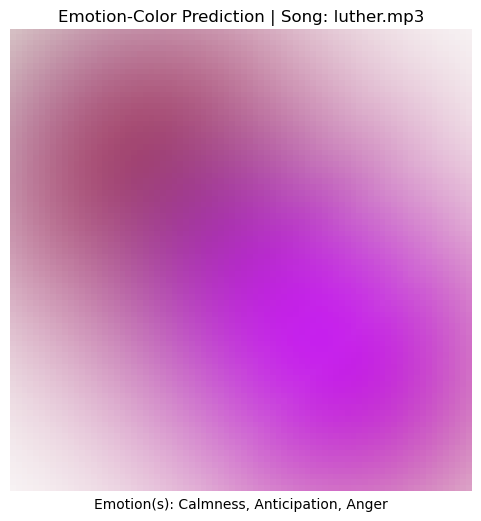

In [200]:
p = Predictor(emotion_map=emotion_mapping)
p.predict(file_path='luther.mp3', model=model)
p.display(padding=3, radius=50, alpha_scale=0.9, resolution_scale=8)